In [1]:
import os
import pandas as pd
import numpy as np
import glob

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_formatrmat = 'retina'

In [2]:
from stesml.data_tools import get_train_and_test_index
from stesml.data_tools import load_data
from stesml.data_tools import series_to_supervised
from stesml.data_tools import get_train_data
from stesml.data_tools import get_test_data

from stesml.model_tools import get_model
from stesml.model_tools import walk_forward_validation
from stesml.model_tools import get_predictions
from stesml.model_tools import get_progress

from stesml.plot_tools import get_plot_data
from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error
from stesml.plot_tools import plot_error_vs_T
from stesml.plot_tools import plot_progress_results

/Users/kmenear/Projects/sulfurTES/sulfurTESenv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data_dir = "../data/Air_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "IG_*_*.csv"))})
scenario_index

,filepath
0,../data/Air_Models/IG_500_390.csv
1,../data/Air_Models/IG_520_300.csv
2,../data/Air_Models/IG_530_300.csv
3,../data/Air_Models/IG_600_560.csv
4,../data/Air_Models/IG_600_400.csv
...,...
135,../data/Air_Models/IG_370_300.csv
136,../data/Air_Models/IG_600_550.csv
137,../data/Air_Models/IG_600_430.csv
138,../data/Air_Models/IG_550_340.csv


In [18]:
model_type = "XGBoost"
is_recurrent = True
n_estimators = 10

In [19]:
train_index, test_index = get_train_and_test_index(scenario_index)

X_train, y_train = get_train_data(scenario_index, train_index, is_recurrent)
X_test, y_test = get_test_data(scenario_index, test_index, is_recurrent)

model = get_model(model_type, n_estimators)

In [20]:
model.fit(X_train, y_train)

y_hat = get_predictions(model, X_test, is_recurrent)

In [21]:
print(r2_score(y_test, y_hat))

-1.7799442189194346


In [22]:
print(mean_squared_error(y_test, y_hat, squared=False))

143.30877376628322


In [23]:
test_df = load_data(scenario_index, test_index)
test_df_plot = get_plot_data(y_hat, test_df, test_index, is_recurrent)

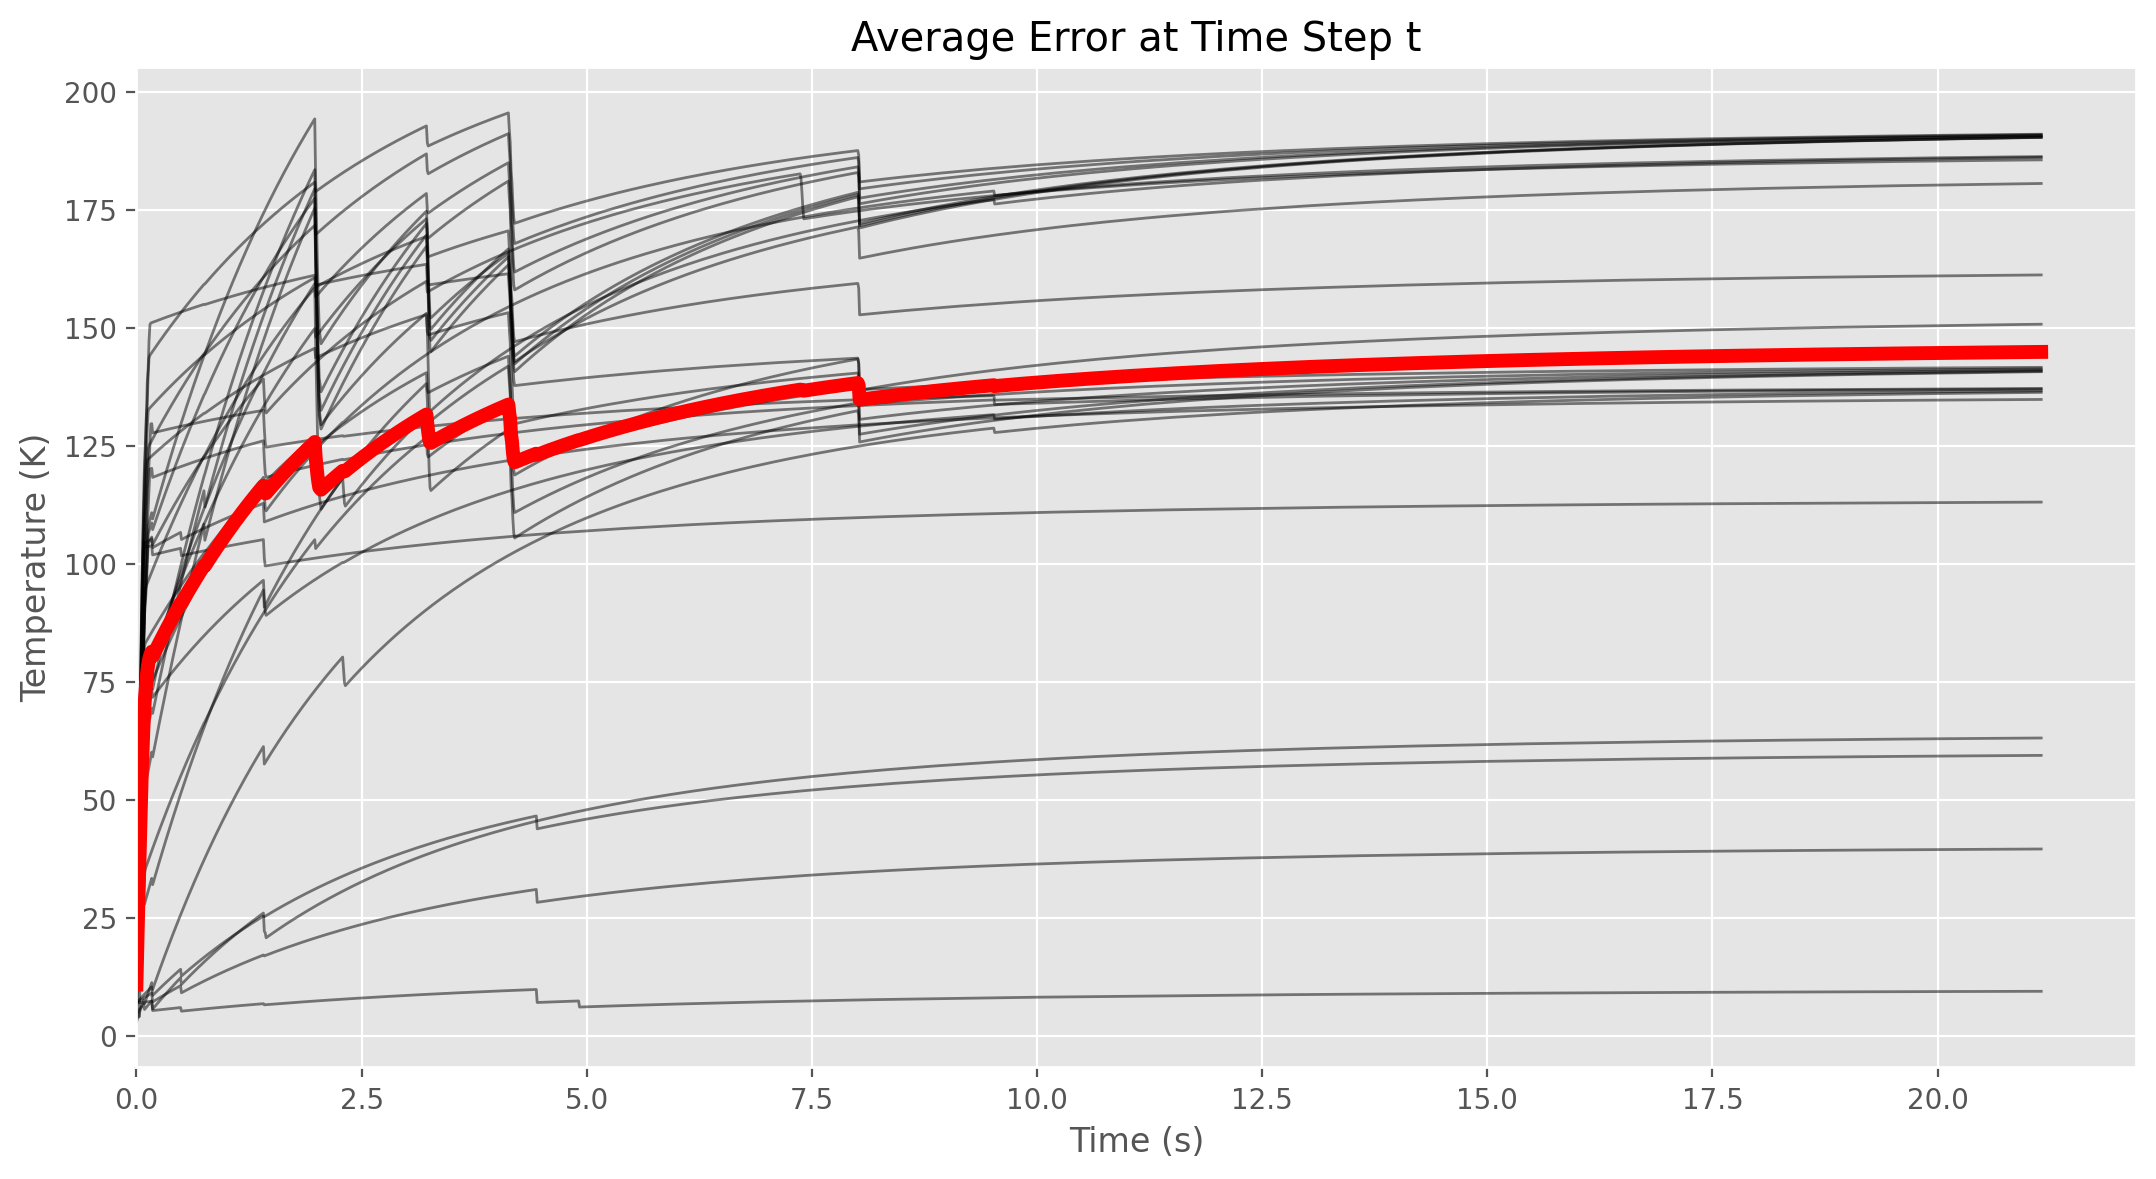

In [24]:
plot_average_error(test_df_plot)

<AxesSubplot:>

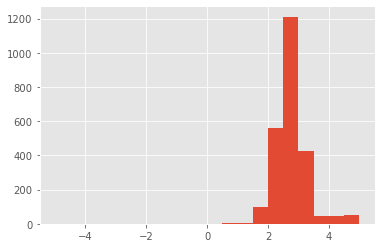

In [25]:
(100*(test_df_plot["Tc"] - test_df_plot["Tc_hat"])/test_df_plot["Tc"]).hist(bins=20, range=(-5, 5))

<AxesSubplot:>

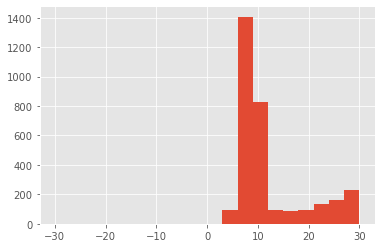

In [26]:
(test_df_plot["Tc"] - test_df_plot["Tc_hat"]).hist(bins=20, range=(-30, 30))

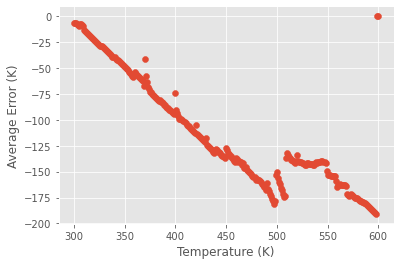

In [27]:
plot_error_vs_T(test_df_plot)

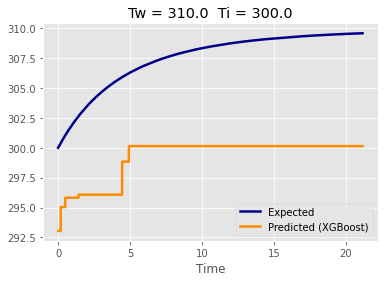

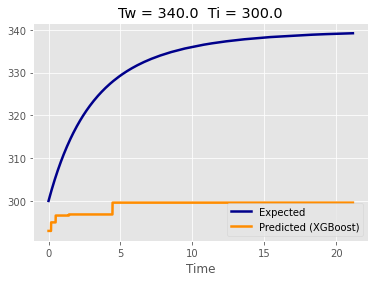

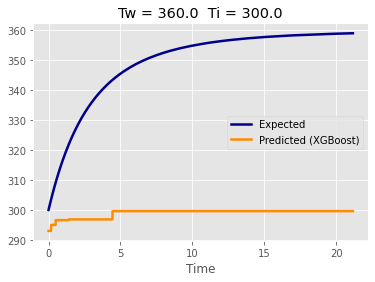

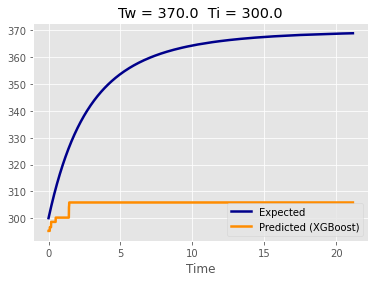

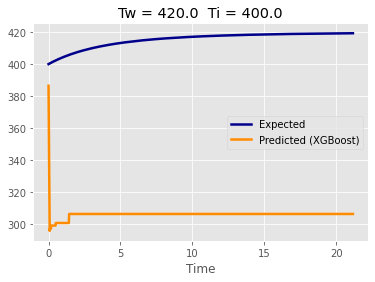

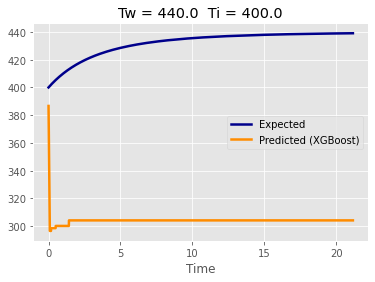

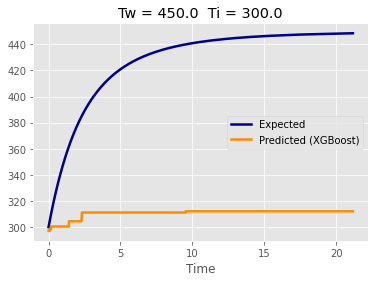

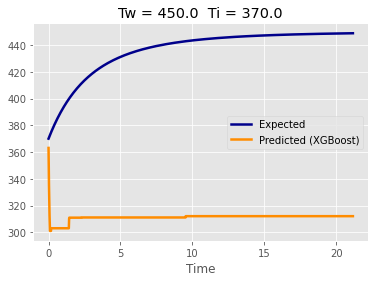

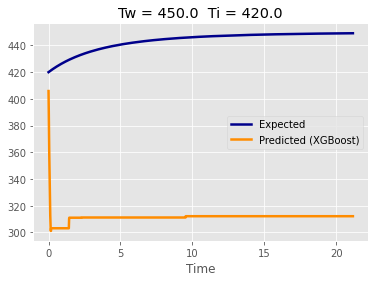

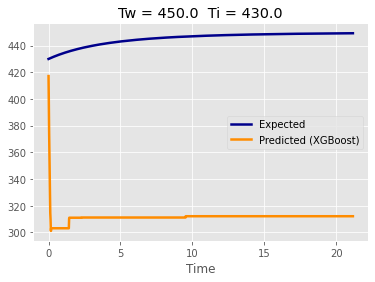

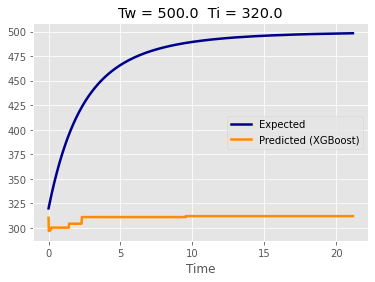

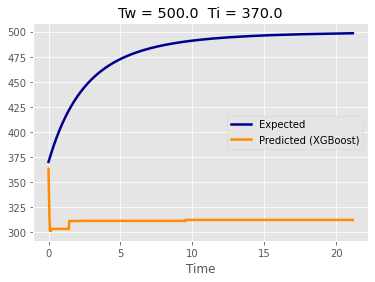

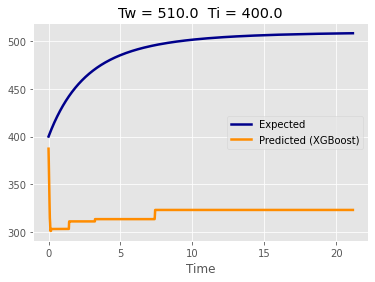

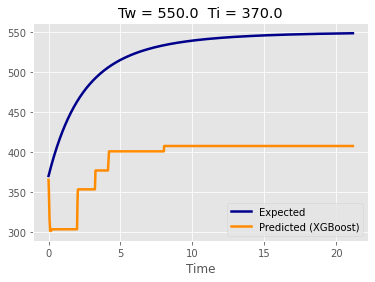

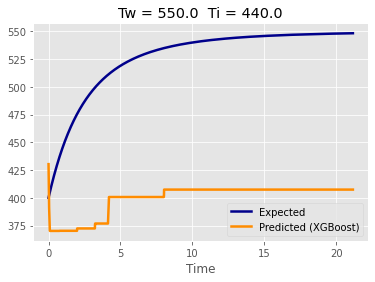

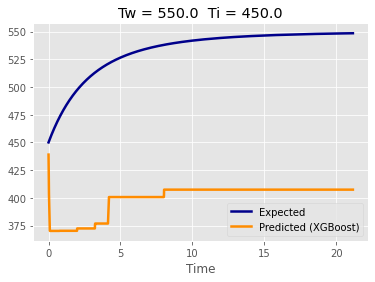

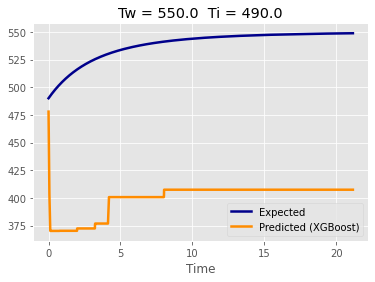

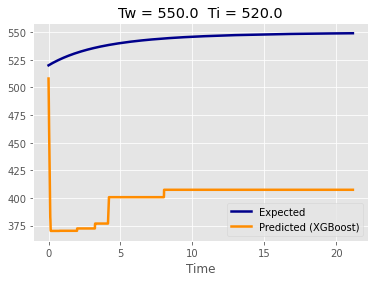

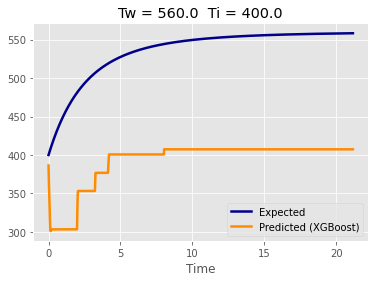

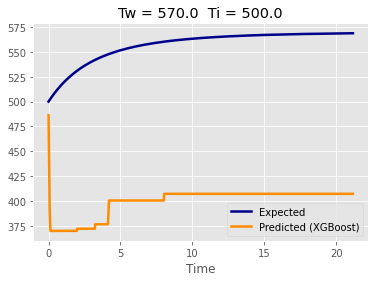

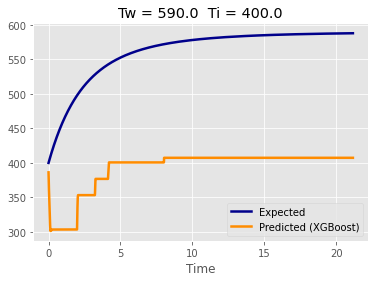

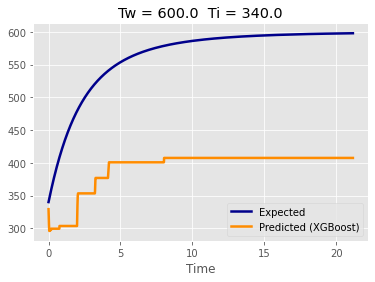

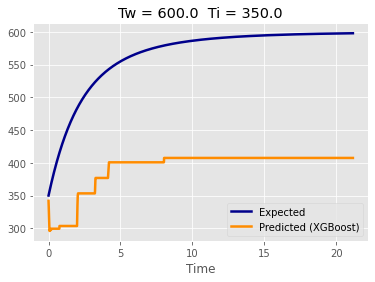

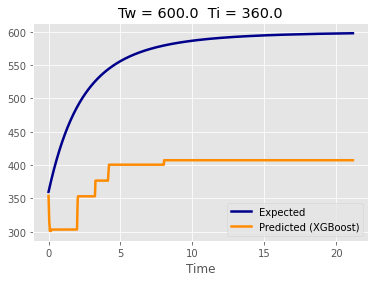

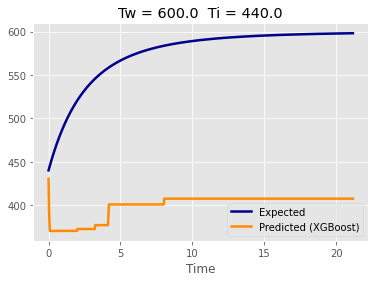

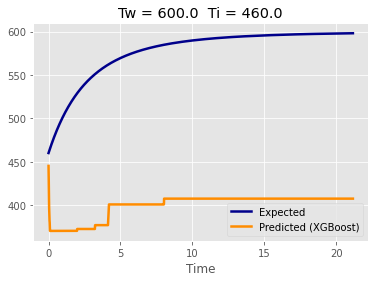

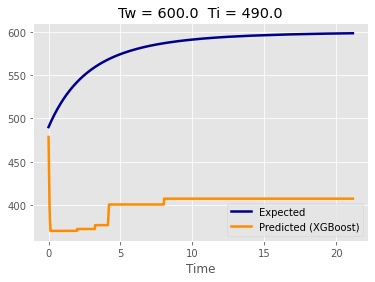

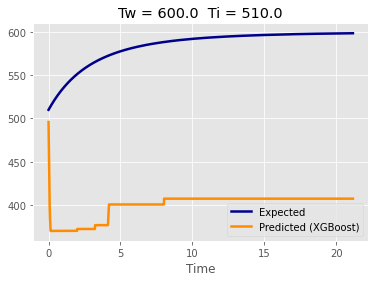

In [28]:
plot_test_results(test_df_plot, model_type)

In [29]:
min_estimators = 8
max_estimators = 10
step_size = 1
num_shuffle_iterations = 2

rmse_history, r2_history = get_progress(model_type, scenario_index, min_estimators, max_estimators, step_size, num_shuffle_iterations, is_recurrent)

# of Estimators: 8, RMSE = 195.74738, r2 = -7.26154
# of Estimators: 9, RMSE = 154.95436, r2 = -3.18066
# of Estimators: 10, RMSE = 152.78211, r2 = -3.51312


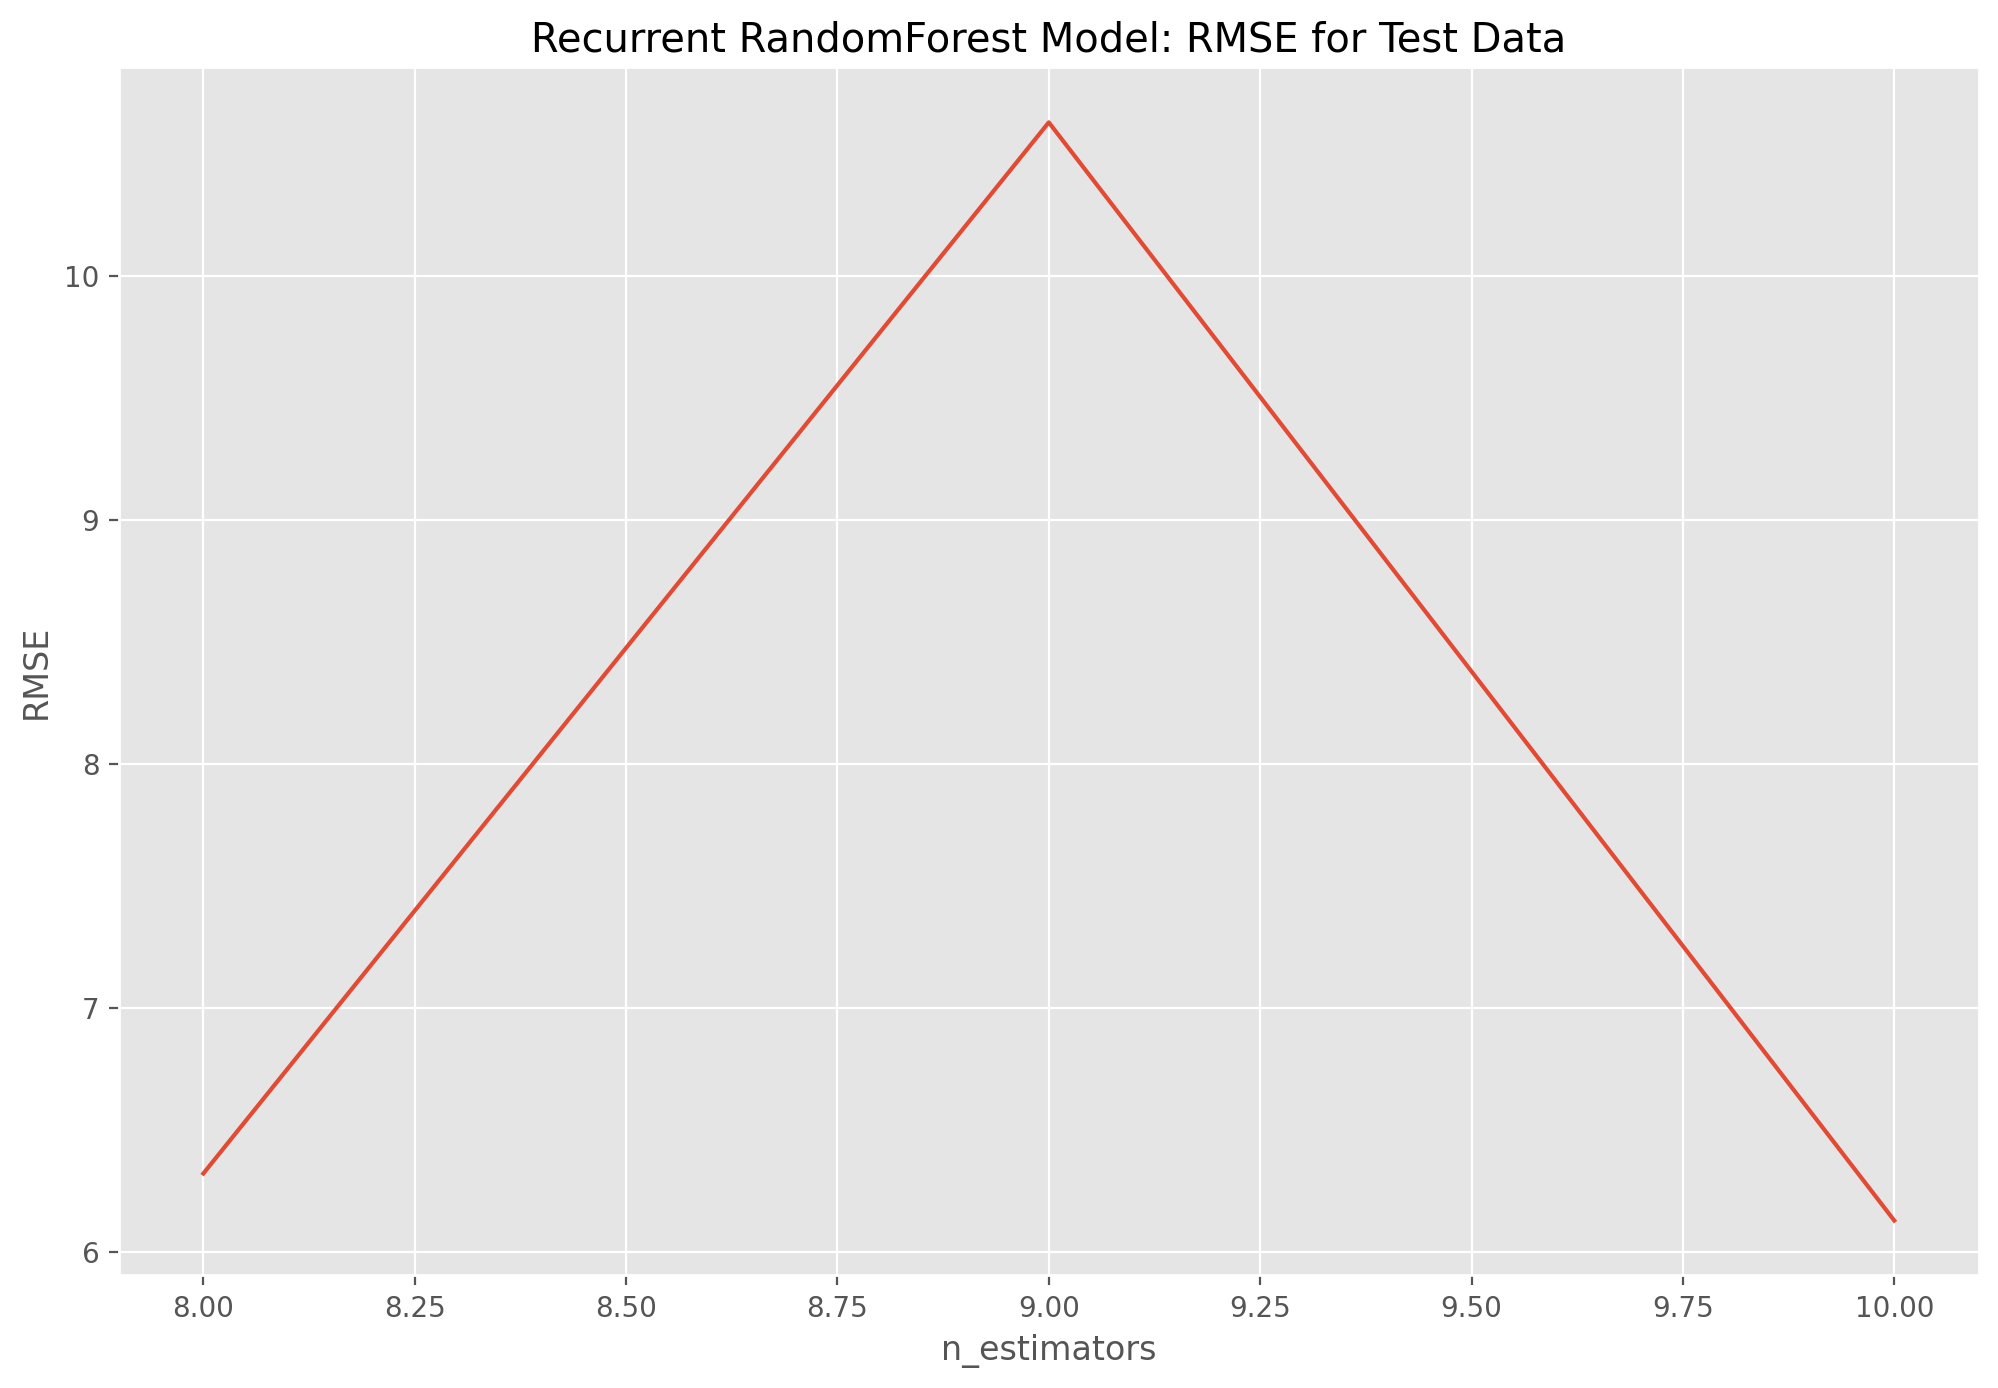

In [16]:
plot_progress_results(rmse_history, model_type, is_recurrent, metric="RMSE")

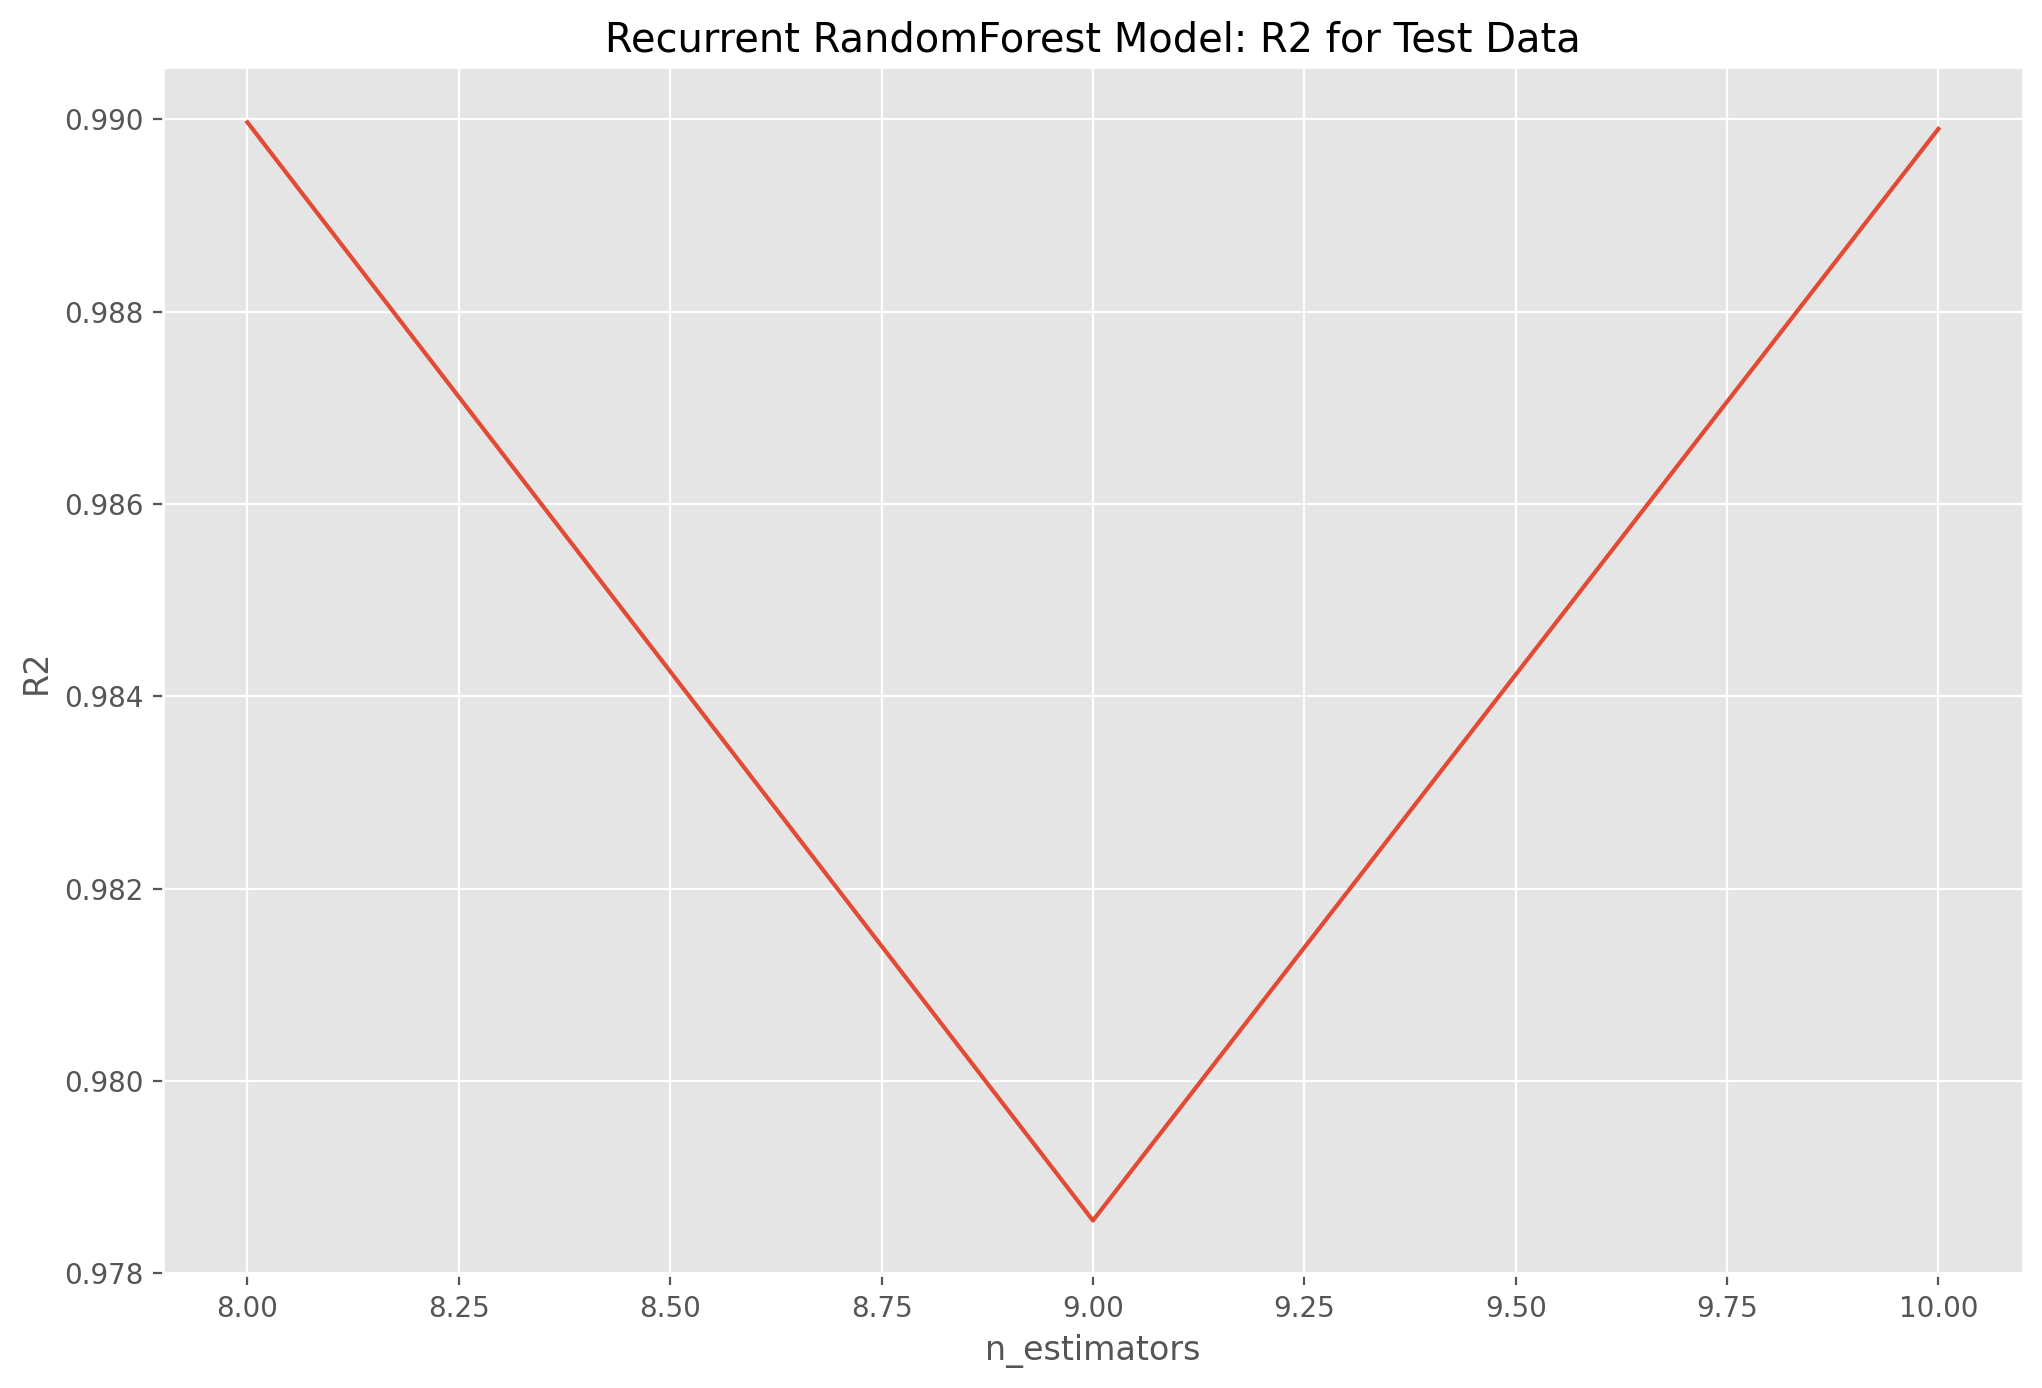

In [17]:
plot_progress_results(r2_history, model_type, is_recurrent, metric="R2")